# Activity Recognition Modelling
#### I am trying to solve a problem of classify actions being performed by a person using data recorded from three sensors placed on that person's body. This data is obtained from [Activity Recognition system based on Multisensor data fusion (AReM) Data Set](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+(AReM)).

#### Dataset contains multiple files segregated into multiple folders where each folder is for a particular type of activity that is our target feature. Each file is a session of activity containing 480 measurements recorded from sensors over a period of 120 seconds. Each entry contains average and variance of 3 RSS values of communication between three sensors placed on chest and ankles of person performing activities.

In [1]:
import os
import itertools
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow import keras

In [3]:
COL_LIST = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']

#### Compiling all dataset into single dataframe

In [4]:
activity_arr = None
activity_label = np.array([])
activity_df = None
data_folder = 'Datasets'
activity_list = os.listdir(data_folder)
for activity in activity_list:
    dataset_list = os.listdir(os.path.join(data_folder, activity))
    for dataset in dataset_list:
        dataset_path = os.path.join(data_folder,activity,dataset)
        df = pd.read_csv(dataset_path, skiprows=5, names=COL_LIST, index_col=0)
        if activity_arr is None:
            activity_arr = df.to_numpy().reshape(1,*df.shape)
        else:
            activity_arr = np.concatenate((activity_arr,df.to_numpy().reshape(1,*df.shape)))
        
        df['activity'] = activity
        df['dataset'] = dataset
        if(activity_df is None):
            activity_df = df
        else:
            activity_df = pd.concat([activity_df,df])
        activity_label = np.append(activity_label,activity)

In [5]:
activity_label

array(['bending1', 'bending1', 'bending1', 'bending1', 'bending1',
       'bending1', 'bending1', 'bending2', 'bending2', 'bending2',
       'bending2', 'bending2', 'bending2', 'cycling', 'cycling',
       'cycling', 'cycling', 'cycling', 'cycling', 'cycling', 'cycling',
       'cycling', 'cycling', 'cycling', 'cycling', 'cycling', 'cycling',
       'cycling', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sitting', 'sitting', 'sitting', 'sitting',
       'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting',
       'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walki

#### Plotting activity sessions of a particular category

In [6]:
def plot_activity(activity, activity_arr):
    datasets = activity_arr[activity_label==activity]
    fig, ax = plt.subplots(datasets.shape[0],2,figsize=(20,5*datasets.shape[0]))
    #print(ax)
    for d in range(datasets.shape[0]):
        #print(d)
        ax[d][0].plot(datasets[d,:,0])
        ax[d][0].plot(datasets[d,:,2])
        ax[d][0].plot(datasets[d,:,4])
        ax[d][0].title.set_text('Average')
        #plt.show()

        #fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
        ax[d][1].plot(datasets[d,:,1])
        ax[d][1].plot(datasets[d,:,3])
        ax[d][1].plot(datasets[d,:,5])
        ax[d][1].title.set_text('Variance')
    plt.show()

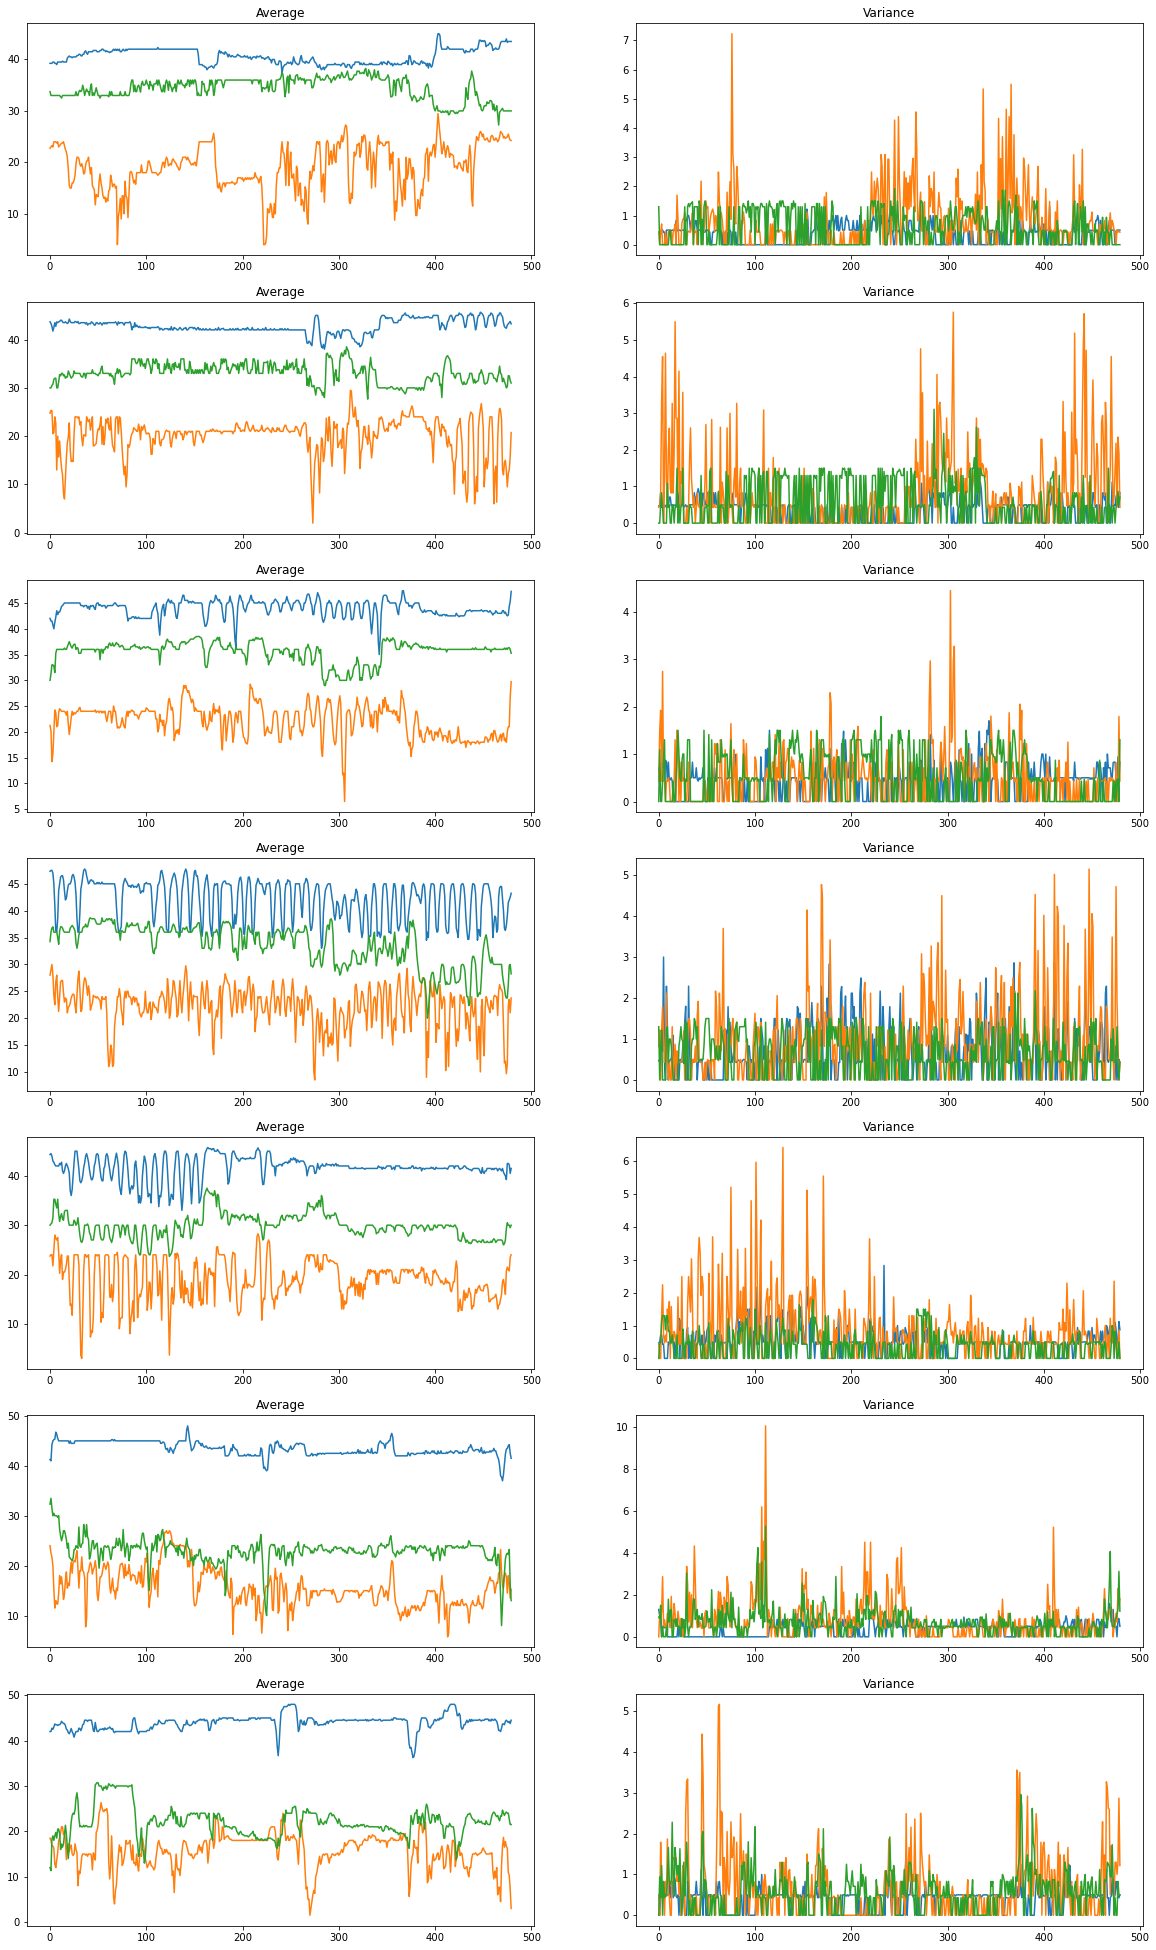

In [7]:
plot_activity('bending1',activity_arr)

#### Transforming data using OneHot Encoding and MinMax Scaling

In [8]:
encoder = OneHotEncoder()
y = encoder.fit_transform(activity_label.reshape(-1,1))

In [9]:
scaler = MinMaxScaler()
scaler.fit(activity_df.loc[:,COL_LIST])

MinMaxScaler()

In [10]:
for x in range(activity_arr.shape[0]):
    activity_arr[x] = (scaler.transform(activity_arr[x]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(activity_arr, y.toarray(), test_size=0.33, random_state=42)

#### Trying with 1-D CNN Network

In [19]:
def create_cnn_model():
    inp_layer = keras.layers.Input((X_train.shape[1],X_train.shape[2]))
    x = keras.layers.Conv1D(64,kernel_size=3,activation='relu')(inp_layer)
    x = keras.layers.MaxPool1D(4)(x)
    x = keras.layers.Conv1D(32,kernel_size=3,activation='relu')(x)
    x = keras.layers.MaxPool1D(4)(x)
    x = keras.layers.Flatten()(x)
    op_layer = keras.layers.Dense(7,activation='softmax')(x)
    model = keras.Model(inp_layer, op_layer)
    model.summary()
    model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["categorical_accuracy"])
    return model

In [20]:
model = create_cnn_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 6)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 478, 64)           1216      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 32)           6176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 6503

In [21]:
model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#reduceLR = keras.callbacks.ReduceLROnPlateau()

In [22]:
fit_history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,callbacks=[checkpoint])

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9928 - categorical_accuracy: 0.0312
Epoch 00001: val_loss improved from inf to 1.94142, saving model to model_init_2021-02-0720_03_54.757687/model-00001-1.96528-0.15517-1.94142-0.10000.h5
2/2 [==============================] - 0s 91ms/step - loss: 1.9653 - categorical_accuracy: 0.1552 - val_loss: 1.9414 - val_categorical_accuracy: 0.1000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9298 - categorical_accuracy: 0.1562
Epoch 00002: val_loss improved from 1.94142 to 1.91289, saving model to model_init_2021-02-0720_03_54.757687/model-00002-1.89533-0.20690-1.91289-0.10000.h5
2/2 [==============================] - 0s 50ms/step - loss: 1.8953 - categorical_accuracy: 0.2069 - val_loss: 1.9129 - val_categorical_accuracy: 0.1000
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.8436 - categorical_accuracy: 0.2500
Epoch 00003: val_loss improved from 1.91289 to 1.89494, saving model to m

Epoch 21/100
1/2 [==============>...............] - ETA: 0s - loss: 0.9542 - categorical_accuracy: 0.6250
Epoch 00021: val_loss improved from 1.22290 to 1.18266, saving model to model_init_2021-02-0720_03_54.757687/model-00021-0.91563-0.60345-1.18266-0.30000.h5
2/2 [==============================] - 0s 44ms/step - loss: 0.9156 - categorical_accuracy: 0.6034 - val_loss: 1.1827 - val_categorical_accuracy: 0.3000
Epoch 22/100
1/2 [==============>...............] - ETA: 0s - loss: 0.9161 - categorical_accuracy: 0.6562
Epoch 00022: val_loss improved from 1.18266 to 1.13355, saving model to model_init_2021-02-0720_03_54.757687/model-00022-0.87979-0.62069-1.13355-0.43333.h5
2/2 [==============================] - 0s 32ms/step - loss: 0.8798 - categorical_accuracy: 0.6207 - val_loss: 1.1336 - val_categorical_accuracy: 0.4333
Epoch 23/100
1/2 [==============>...............] - ETA: 0s - loss: 0.8583 - categorical_accuracy: 0.6562
Epoch 00023: val_loss improved from 1.13355 to 1.06916, saving mod

Epoch 42/100
1/2 [==============>...............] - ETA: 0s - loss: 0.3236 - categorical_accuracy: 0.9688
Epoch 00042: val_loss did not improve from 0.65066
2/2 [==============================] - 0s 27ms/step - loss: 0.3257 - categorical_accuracy: 0.9483 - val_loss: 0.6649 - val_categorical_accuracy: 0.8000
Epoch 43/100
1/2 [==============>...............] - ETA: 0s - loss: 0.3253 - categorical_accuracy: 1.0000
Epoch 00043: val_loss improved from 0.65066 to 0.61959, saving model to model_init_2021-02-0720_03_54.757687/model-00043-0.31711-0.96552-0.61959-0.83333.h5
2/2 [==============================] - 0s 34ms/step - loss: 0.3171 - categorical_accuracy: 0.9655 - val_loss: 0.6196 - val_categorical_accuracy: 0.8333
Epoch 44/100
1/2 [==============>...............] - ETA: 0s - loss: 0.3014 - categorical_accuracy: 0.9688
Epoch 00044: val_loss improved from 0.61959 to 0.61591, saving model to model_init_2021-02-0720_03_54.757687/model-00044-0.28972-0.98276-0.61591-0.80000.h5
2/2 [==========

Epoch 94/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0323 - categorical_accuracy: 1.0000
Epoch 00094: val_loss did not improve from 0.61154
2/2 [==============================] - 0s 29ms/step - loss: 0.0300 - categorical_accuracy: 1.0000 - val_loss: 0.7179 - val_categorical_accuracy: 0.8333
Epoch 95/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0251 - categorical_accuracy: 1.0000
Epoch 00095: val_loss did not improve from 0.61154
2/2 [==============================] - 0s 32ms/step - loss: 0.0292 - categorical_accuracy: 1.0000 - val_loss: 0.7163 - val_categorical_accuracy: 0.8333
Epoch 96/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0315 - categorical_accuracy: 1.0000
Epoch 00096: val_loss did not improve from 0.61154
2/2 [==============================] - 0s 30ms/step - loss: 0.0281 - categorical_accuracy: 1.0000 - val_loss: 0.7164 - val_categorical_accuracy: 0.8333
Epoch 97/100
1/2 [==============>...............] - ETA: 0s - loss: 0.024

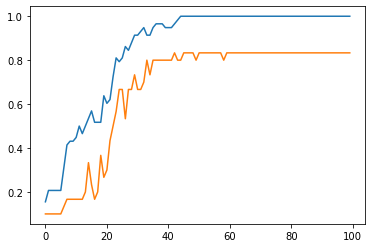

In [23]:
plt.plot(fit_history.history['categorical_accuracy'])
plt.plot(fit_history.history['val_categorical_accuracy'])
plt.show()

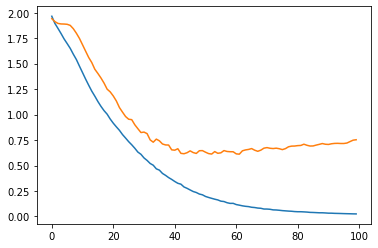

In [24]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.show()

In [25]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 0s/step - loss: 0.7531 - categorical_accuracy: 0.8333


[0.7531397342681885, 0.8333333134651184]

#### After multiple attempts of tuning 1-D CNN based model, maximum accuracy of around 83% was acheived

#### Trying with 2-D CNN by transforming data shape

In [34]:
X_train_2d = X_train.reshape(X_train.shape + tuple([1]))
X_test_2d = X_test.reshape(X_test.shape + tuple([1]))

In [103]:
def create_2d_cnn_model():
    inp_layer = keras.layers.Input(X_train_2d.shape[1:])
    x = keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inp_layer)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Flatten()(x)
    op_layer = keras.layers.Dense(7,activation='softmax')(x)
    model = keras.Model(inp_layer, op_layer)
    model.summary()
    model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["categorical_accuracy"])
    return model

In [104]:
model = create_2d_cnn_model()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 480, 6, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 478, 4, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 239, 2, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 15296)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 107079    
Total params: 107,399
Trainable params: 107,399
Non-trainable params: 0
_________________________________________________________________


In [105]:
model_name = 'model_2d_cnn' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [106]:
fit_history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,callbacks=[checkpoint])

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9483 - categorical_accuracy: 0.1562
Epoch 00001: val_loss improved from inf to 2.42730, saving model to model_2d_cnn_2021-02-0720_31_27.849032/model-00001-2.15199-0.18966-2.42730-0.16667.h5
2/2 [==============================] - 0s 79ms/step - loss: 2.1520 - categorical_accuracy: 0.1897 - val_loss: 2.4273 - val_categorical_accuracy: 0.1667
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 1.6920 - categorical_accuracy: 0.5312
Epoch 00002: val_loss improved from 2.42730 to 2.03129, saving model to model_2d_cnn_2021-02-0720_31_27.849032/model-00002-1.84755-0.37931-2.03129-0.26667.h5
2/2 [==============================] - 0s 38ms/step - loss: 1.8476 - categorical_accuracy: 0.3793 - val_loss: 2.0313 - val_categorical_accuracy: 0.2667
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.7145 - categorical_accuracy: 0.4062
Epoch 00003: val_loss improved from 2.03129 to 1.77343, saving model 

1/2 [==============>...............] - ETA: 0s - loss: 0.4264 - categorical_accuracy: 0.8750
Epoch 00022: val_loss improved from 0.84009 to 0.82752, saving model to model_2d_cnn_2021-02-0720_31_27.849032/model-00022-0.35670-0.93103-0.82752-0.76667.h5
2/2 [==============================] - 0s 38ms/step - loss: 0.3567 - categorical_accuracy: 0.9310 - val_loss: 0.8275 - val_categorical_accuracy: 0.7667
Epoch 23/100
1/2 [==============>...............] - ETA: 0s - loss: 0.3080 - categorical_accuracy: 1.0000
Epoch 00023: val_loss improved from 0.82752 to 0.79890, saving model to model_2d_cnn_2021-02-0720_31_27.849032/model-00023-0.33718-1.00000-0.79890-0.80000.h5
2/2 [==============================] - 0s 35ms/step - loss: 0.3372 - categorical_accuracy: 1.0000 - val_loss: 0.7989 - val_categorical_accuracy: 0.8000
Epoch 24/100
1/2 [==============>...............] - ETA: 0s - loss: 0.3138 - categorical_accuracy: 1.0000
Epoch 00024: val_loss did not improve from 0.79890
2/2 [===================

Epoch 47/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0845 - categorical_accuracy: 1.0000
Epoch 00047: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 30ms/step - loss: 0.0896 - categorical_accuracy: 1.0000 - val_loss: 0.7592 - val_categorical_accuracy: 0.8333
Epoch 48/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0864 - categorical_accuracy: 1.0000
Epoch 00048: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 30ms/step - loss: 0.0831 - categorical_accuracy: 1.0000 - val_loss: 0.7441 - val_categorical_accuracy: 0.8000
Epoch 49/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0847 - categorical_accuracy: 1.0000
Epoch 00049: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 34ms/step - loss: 0.0818 - categorical_accuracy: 1.0000 - val_loss: 0.7404 - val_categorical_accuracy: 0.8000
Epoch 50/100
1/2 [==============>...............] - ETA: 0s - loss: 0.082

Epoch 74/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0349 - categorical_accuracy: 1.0000
Epoch 00074: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 30ms/step - loss: 0.0341 - categorical_accuracy: 1.0000 - val_loss: 0.7638 - val_categorical_accuracy: 0.8333
Epoch 75/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0352 - categorical_accuracy: 1.0000
Epoch 00075: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 31ms/step - loss: 0.0334 - categorical_accuracy: 1.0000 - val_loss: 0.7647 - val_categorical_accuracy: 0.8333
Epoch 76/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0314 - categorical_accuracy: 1.0000
Epoch 00076: val_loss did not improve from 0.73686
2/2 [==============================] - 0s 33ms/step - loss: 0.0329 - categorical_accuracy: 1.0000 - val_loss: 0.7748 - val_categorical_accuracy: 0.8333
Epoch 77/100
1/2 [==============>...............] - ETA: 0s - loss: 0.027

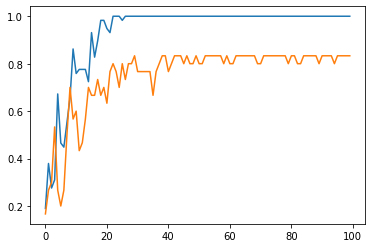

In [107]:
plt.plot(fit_history.history['categorical_accuracy'])
plt.plot(fit_history.history['val_categorical_accuracy'])
plt.show()

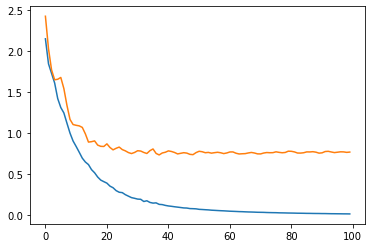

In [108]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.show()

In [109]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.7717 - categorical_accuracy: 0.8333


[0.7717368602752686, 0.8333333134651184]

#### Even after using 2-D CNN based model, we were able only to get similar accuracy but not better.

#### Our model seems to be performing well enough to be used as a discriminator. We will use architecture similar to our CNN based model to be used as a discriminator

In [27]:
def define_discriminator(in_shape=(480,6)):
    inp_layer = keras.layers.Input(in_shape)
    x = keras.layers.Conv1D(32,kernel_size=3,activation='relu')(inp_layer)
    x = keras.layers.MaxPool1D(1)(x)
    x = keras.layers.Conv1D(32,kernel_size=3,activation='relu')(x)
    x = keras.layers.MaxPool1D(1)(x)
    x = keras.layers.Flatten()(x)
    op_layer = keras.layers.Dense(1,activation='sigmoid')(x)
    model = keras.Model(inp_layer, op_layer)
    model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["categorical_accuracy"])
    return model

In [32]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples,1))
    return X, y

In [38]:
def generate_fake_samples(n_samples, sample_shape=(480,6)):
    X = np.random.rand(n_samples,*sample_shape)
    y = np.zeros(n_samples)
    return X, y

In [41]:
def train_discriminator(model, dataset, n_iter=50,n_batch=64):
    half_batch = n_batch//2
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset,half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print("iter {0}, real acc {1}, fake acc {2}".format(i, real_acc*100, fake_acc*100))

In [40]:
def define_generator(in_shape=(480,6)):
    inp_layer = keras.layers.Input(in_shape)
    x = keras.layers.Conv1D(32,kernel_size=3,activation='relu')(inp_layer)
    x = keras.layers.MaxPool1D(1)(x)
    x = keras.layers.Conv1D(32,kernel_size=3,activation='relu')(x)
    x = keras.layers.MaxPool1D(1)(x)
    x = keras.layers.Flatten()(x)
    op_layer = keras.layers.Dense(1,activation='sigmoid')(x)
    model = keras.Model(inp_layer, op_layer)
    model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["categorical_accuracy"])
    return model

32

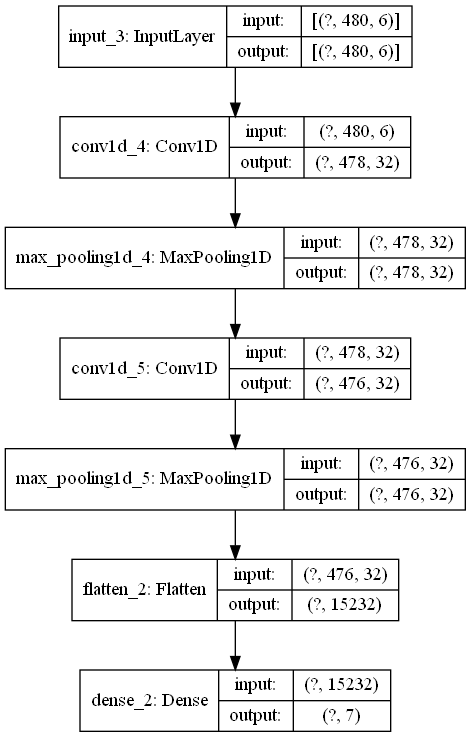

In [43]:
model = define_discriminator()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)